In [3]:
import scipy.special
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches


In [1]:
def NormalEIRandomMatrix(n, f=0.5, ve=1, vi=1, me=1, mi=-1, meanSubstract = True):
    ne = int(np.round(n*f))
    ni = n - ne;
    
    is_e = np.repeat(False, n);
    is_e[np.random.choice(np.arange(0,n), size = ne, replace=False)] = True;
    
    Je = np.random.randn(n, n)*np.sqrt(ve);#+me;
    Ji = np.random.randn(n, n)*np.sqrt(vi);#+mi;
    
    J = np.multiply(Je, is_e) + np.multiply(Ji, ~is_e)
    Jmean = np.tile(J.mean(1), (n,1)).transpose();
    
    m = np.repeat(me, n);
    m[~is_e] = mi;
    M = np.tile(m, (n,1));
    
    Jtot = J - Jmean*meanSubstract + M;
    
    return Jtot, is_e;


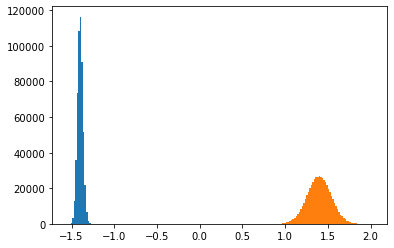

In [310]:
f = 0.5;
n = 2**10;
a = 0.05

ve = 1/n/a; vi = 1/n;
me = 10*np.sqrt(np.max([ve,vi])); 
mi = -f*me/(1-f); #such that f*me + (1-f)*mi = 0 - balanced

Jtot,is_e = NormalEIRandomMatrix(n, f, ve, vi, me, mi);

bins = np.linspace(Jtot.min(), Jtot.max(), 200)
plt.hist(Jtot[:,~is_e].flatten(), bins);
plt.hist(Jtot[:,is_e].flatten(),  bins);


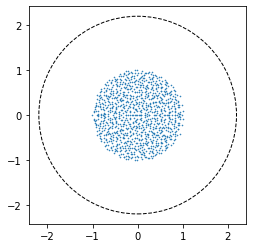

In [332]:
eig, ev = np.linalg.eig(Jtot)

fig,ax = plt.subplots()
ax.scatter(eig.real, eig.imag, s=0.3) 
ax.set_aspect(1)

p = matplotlib.patches.Circle((0,0), radius = np.sqrt(1-f+f/a),
                                   fill=False, linestyle = '--')
ax.add_patch(p);


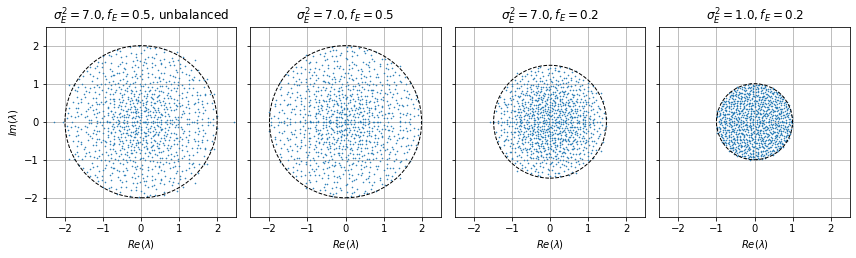

In [346]:
alphas = [1/7, 1/7, 1/7, 1];
fs = [0.5, 0.5, 0.2, 0.2];
fig, axs = plt.subplots(1,4, figsize=(12,4))

for i_a in range(len(alphas)):  
    
    ve = 1/n/alphas[i_a]; vi = 1/n;
    me = 10*np.sqrt(np.max([ve,vi])); 
    f = fs[i_a];
    mi = -f*me/(1-f); #such that f*me + (1-f)*mi = 0 - balanced

    Jtot,is_e = NormalEIRandomMatrix(n, f, ve, vi, me, mi, meanSubstract=(i_a != 0));
    eig, ev = np.linalg.eig(Jtot)
    
    axs[i_a].set_aspect(1)
    axs[i_a].scatter(eig.real, eig.imag, s=0.3) 
    axs[i_a].set_xlim([-2.5,2.5])
    axs[i_a].set_ylim([-2.5,2.5])
    axs[i_a].set_xlabel('$Re(\lambda)$')
    if(i_a == 0): axs[i_a].set_ylabel('$Im(\lambda)$')
    
    if(i_a > 0): axs[i_a].set_yticklabels([])
    
    
    p = matplotlib.patches.Circle((0,0), radius = np.sqrt(1-f+f/alphas[i_a]),
                                   fill=False, linestyle = '--')

    axs[i_a].add_patch(p)
    axs[i_a].title.set_text('$\sigma^2_E=$' + str(np.round(1/alphas[i_a], 2)) + "$, f_E=$"+   str(np.round(f, 2)));
    if(i_a == 0): axs[i_a].title.set_text(axs[i_a].title.get_text() + ", unbalanced")
    
    axs[i_a].grid()
    axs[i_a].set_axisbelow(True)
    
plt.tight_layout()
plt.savefig('support_EI.png', dpi = 128)

In [343]:
n

1024

In [165]:
def RadialBins(nbins, left, right):
    rborders = np.zeros(nbins+1) 

    rborders[0] = 0;
    rborders[1] = 1;
    for i in range(2,len(rborders)): rborders[i] = np.sqrt(2*rborders[i-1]**2 - rborders[i-2]**2)#np.sqrt(2*rborders[i-1]**2 - rborders[i-2]**2)


    bins = (rborders - rborders.min())*(right-left)/(rborders.max() - rborders.min()) + left;
    
    rs = (bins[1:None] + bins[0:-1])/2
    areas = np.multiply(rs, np.diff(bins))
    
    return bins, rs, areas;

In [301]:
#nrepeats = 4;

f = 0.5;
ns = (2**9, 2**10, 2**11, 2**12);
a = 0.15



eigs = [];#np.empty((nrepeats, n), dtype = np.complex)

for i_r in range(len(ns)):
    ve = 1/ns[i_r]/a; vi = 1/ns[i_r];
    me = 10*np.sqrt(np.max([ve,vi])); 
    mi = -f*me/(1-f); #such that f*me + (1-f)*mi = 0 - balanced

    Jtot,is_e = NormalEIRandomMatrix(ns[i_r], f, ve, vi, me, mi);
    eig, ev = np.linalg.eig(Jtot)
    eigs.append(eig);


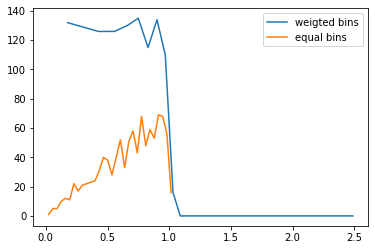

In [349]:
bins, rs, areas = RadialBins(50, 0, 2.5)

h, rb = np.histogram(np.abs(eig), bins = bins, density=False)
h2, rb2  = np.histogram(np.abs(eig), 30)

#rho = np.divide(h,np.power(r,0));
#rho = np.divide(rho/rho.sum(), np.diff(rb));
plt.plot((rb[1:None] + rb[0:-1])/2, h)
plt.plot((rb2[1:None] + rb2[0:-1])/2, h2)
plt.legend(("weigted bins", "equal bins"))

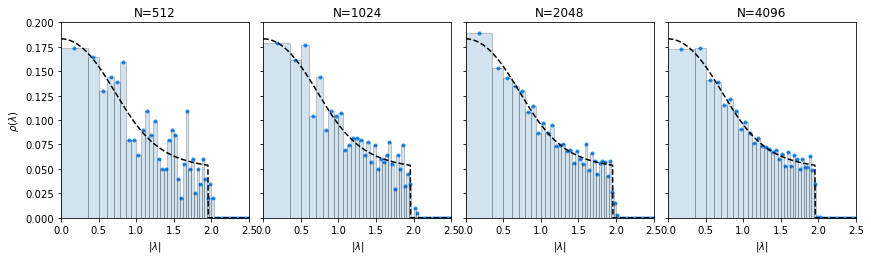

In [350]:
theoretical = lambda z, v: np.multiply(1/(2*np.pi*v)*(1+v - z*(v-1)**2/np.sqrt((v**2+(z*(v-1))**2)) ), z <= (1+v)/2)


bins, rs, areas = RadialBins(50, 0, 2.5)
densities = np.empty((len(ns), bins.shape[0]-1))

for i_r in range(len(ns)):
    h, rb = np.histogram(np.abs(eigs[i_r]), bins = bins, density=False)
    density = h/np.multiply(h, areas ).sum()*1/np.pi/2;
    densities[i_r] = density;
    

fig, axs = plt.subplots(1, len(ns), figsize=(12,4))

for i_r in range(len(ns)):  
    axs[i_r].scatter(rs, densities[i_r], marker='.', color='dodgerblue')
    axs[i_r].bar(rs, densities[i_r], width = np.diff(rb), edgecolor = 'black', alpha = 0.2)

    rs2 = np.linspace(bins.min(), bins.max(), 500);
    axs[i_r].plot(rs2, theoretical(rs2**2,  1/a), color='black', linestyle = '--')
    axs[i_r].set_aspect(13)
    
    axs[i_r].set_ylim([0,0.2])
    axs[i_r].set_xlim([0,2.5])
    axs[i_r].set_xlabel('$|\lambda|$');
    axs[i_r].set_title('N=' + str(ns[i_r])); 
    
    if(i_r > 0): axs[i_r].set_yticklabels([])
        
    if(i_r == 0):
        axs[i_r].set_ylabel('$\\rho(\lambda)$'); me
   

plt.tight_layout()
plt.savefig('distribution_EI.png', dpi = 128)

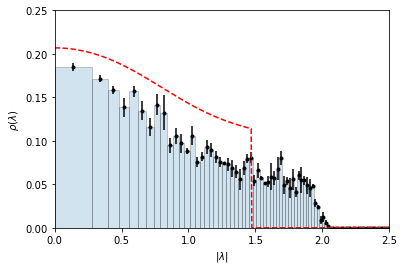

In [304]:
density = densities.mean(0)
err = densities.std(0)/np.sqrt(densities.shape[0])

fig,ax = plt.subplots();

ax.scatter(rs, density, marker='.', color='black')
ax.errorbar(rs, density, err, ls='none', color='black')
ax.bar(rs, density, width = np.diff(rb), edgecolor = 'black', alpha = 0.2)

rs2 = np.linspace(bins.min(), bins.max(), 500);
ax.plot(rs2, theoretical(rs2**2, ve*n), color='red', linestyle = '--')

plt.ylim([0,0.25])
plt.xlim([0, 2.5])#np.ceil(bins.max())])
plt.xlabel('$|\lambda|$');
plt.ylabel('$\\rho(\lambda)$');

In [285]:
(eigs[0]).shape

(2048,)

'$\\sigma^2_E=$1.0$, f_E=$0.2'

In [334]:
1/3.2

0.3125

In [336]:
5/16

0.3125

In [348]:
f = 0.5;
ns = (2**9, 2**10, 2**11, 2**12);
a = 0.15
